# The Transiting Exoplanet Survey Sattelite (TESS)

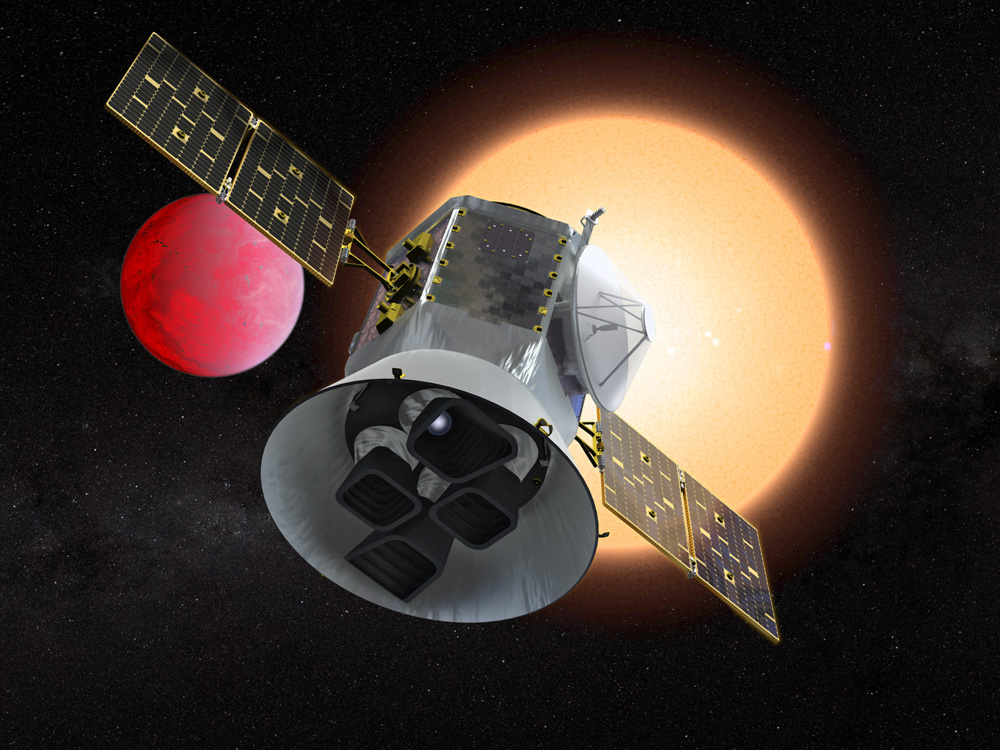 
*Image Credit: NASA*

The [Transiting Exoplanet Survey Satellite (TESS)](https://heasarc.gsfc.nasa.gov/docs/tess/objectives.html) is a NASA-sponsored Astrophysics Explorer-class mission that is performing a near all-sky survey to search for planets transiting nearby stars. The primary goal of TESS is to discover planets smaller than Neptune that transit stars bright enough to enable follow-up spectroscopic observations that can provide planet masses and atmospheric compositions. 

Now in its extended mission, TESS also carries out a wide range of astrophysics investigations as part of its regular observations - 
including stellar, extragalactic, and transient objects.  

## TESS-Vectors Introduction

The TESS-Vectors repository is an effort to take TESS mission engineering products and translate them into a more convenient, value-added form factor for convenient use by end-users.  

The information contained inside of these files is:

    - Cadence #: Cadence index from the source tpf
    - MidTime: The exposure midpoint in spacecraft time (i.e. tpf.time - tpf.timecorr)
    - TimeCorr: The Time Correction for spacecraft to Barycentric time at that cadence
    - ExpTime: The final cadence binning (20s/120s/FFI)
    - Sector: The TESS observing Sector for the source data
    - Camera: The TESS camera for the source data
    - Quat_Start: The timestamp of the earliest quaternion used in the bin
    - Quat_Stop: The timestamp of the last quaternion used in the bin
    - Quat_MIN_FOM: The worst Figure of Merit from the source quaternions
    - Quat_MIN_NUM_GSUSED: The lowest number of guide stars used in the source quaternions
    - Quat_NBinned: The number of quaternions binned into this final result.
    - Quat[1-4]_Med: The Quaternion #[1-4] median value from the binned values 
    - Quat[1-4]_StdDev: The standard deviation of Quaternion #[1-4] binned values
    - Quat[1-4]_SigClip: The Sigma-Clipped Standard Deviation of Quaternion #[1-4] binned values
    - Quat[1-4]_CRM_Med: The Quaternion #[1-4] median value with the highest and lowest values excluded 


The information contained in these files generally comes from quaternion (\*-quat.fits) and earth-moon information (\*-emi.fits) [engineering files](https://archive.stsci.edu/missions-and-data/tess/data-products.html#mod_eng) that have been reprocessed to present results at the same time-cadence/binning as end usser TPFs'/lightcurves.

There is one TESS-Vectors file for every Cadence(20-second/120-second/FFI) and Camera/Sector.  We have also created some diagnostic plots to help guide the understanding of TESS observations for a given sector.  

## TESS-Vectors Use
We envision there to be a variety of use cases for the data contained within these products, and demonstrate two of them below - using the TESS-Vectors information to model the TESS pointing jitter noise via quaternion data, and using the TESS Earth-Moon Information to select TESS observations with a low scattered-light background.  We don't believe this will be the full extent of the use of these products - if you find a cool use case for them let us know!  

If you have any questions, comments, or concerns regarding the use of these vectors, or have suggestions as to the improvement of these products, please contact the [TESS Science Support Center Helpdesk](https://heasarc.gsfc.nasa.gov/docs/tess/helpdesk.html) at tesshelp@bigbang.gsfc.nasa.gov

### TESS Jitter Noise-modelling using the Quaternion Vectors
TESS takes an exposure every 2-seconds.  These exposures are then co-added onboard the sattelite, due to memory and data transfer constraints, to the FFI exposure time for the full CCD and to 20s or 120s for targets awarded a high-cadence postage stamp.  These are then downlinked for final pipeline processing. 

TESS pointing varies slightly over time, and it is calculated after every 2-second exposure on sky using a reference catalog of stars.  An offset vector is then calculated to return the TESS pointing to its nominal location.  These vectors are called ***Quaternions***.  
***It might be nice to create an image demonstrating this***

The centroids of a pixel can calculated from the final science calibrated target pixel file.  However, this *measured* centroid is also subject to other effects not due solely due to TESS's pointing - this includes, but is not limited to:
 - variability from other objects on the CCD
 - movement from the object itself
 - centroid movement from binary rotation/etc
 - and more!

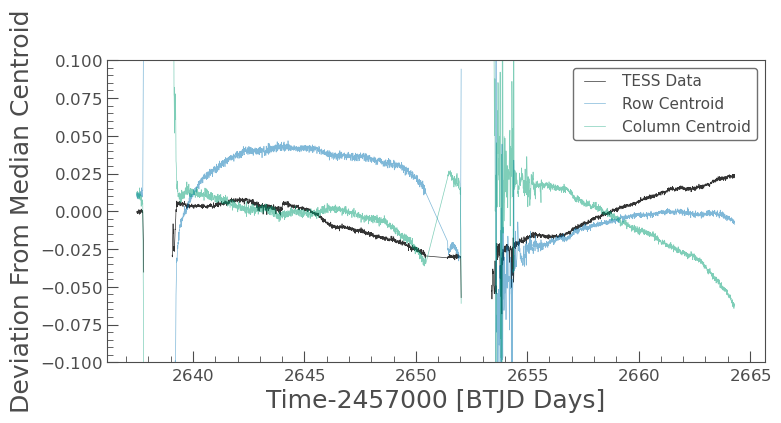 
*Image Credit https://github.com/tylerapritchard/TESSGI_Tut_NGC4151/blob/main/NGC4151.ipynb*  
***make a better centroid image***

The TESS-Vectors quaternions will allow us to build a noise-model from the TESS spacecraft pointing data itself to separate out noise jitter from the spacecraft itself and that caused by other, real astrophysical sources - allowing us to improve our meausrements

#### A note regarding TESS Quaternions
As discussed above, quaternions are calculated at a native time sampling of 2-seconds.  However, TESS Science observations are binned to either 20-seconds/120-seconds/200-seconds/10-minutes/30-minutes depending on the science product type.  

TESS Vectors therefore takes these native 2-second quaternions and re-bins them using the median quaternion value and reporting some summary statistics in the form of the standard deviation and sigma-clipped standard deviation.

For this example we will be using the quaternion standard deviation as *this is a measure of how stable the TESS pointing is for a given observation*


In [3]:
# Imports for creating this noise model
%matplotlib inline
import lightkurve as lk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from astropy.stats import sigma_clip, sigma_clipped_stats
from fbpca import pca

In [4]:
rlcs = lk.search_lightcurve("Pi Men C", exptime=120, author="SPOC").download_all(quality_bitmask=1 | 2 | 4 | 8 | 32 | 128)

In [6]:
lcs = []
for lc in rlcs:
    lcs.append(lc.select_flux("sap_flux") + lc.sap_bkg)
lcs = lk.LightCurveCollection(lcs)

In [7]:
# Use one LC for now
TESSVectors_Loc='quaternion_products/120_Cadence/'
lc = lcs[0]
df = pd.read_csv(f"{TESSVectors_Loc}/TessQuats_S001_C4_120.csv", comment="#")[
    lc.quality_mask
]

k = np.isfinite(np.asarray(lc.sap_bkg.value)) & np.isfinite(np.asarray(lc.sap_flux.value)) & np.isfinite(np.asarray(lc.sap_flux_err.value))
lc = lc[k]
df = df[k]

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

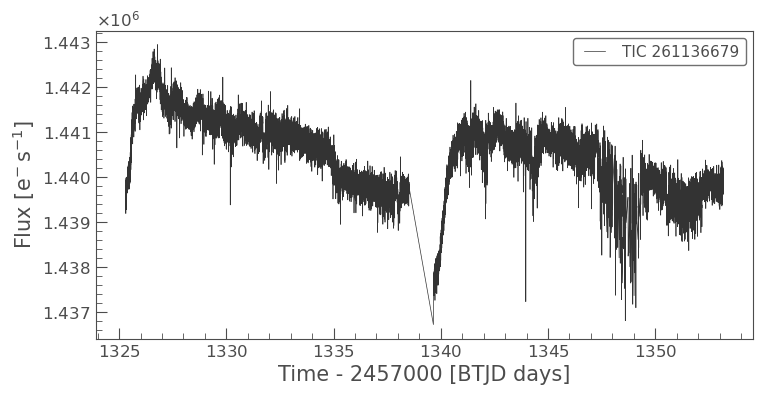

In [13]:
lc.plot(title="Pi Men C")

We're going to find roughly where the orbit downlinks are or any other large gaps in the data...

In [14]:
breakpoints = np.diff(lc.time.value) / np.median(np.diff(lc.time.value))
breakpoints = np.hstack([0, np.where(breakpoints > 50)[0] + 1, len(lc)])
x = np.arange(len(lc))
masks = [(x >= a) & (x < b) for a, b in zip(breakpoints[:-1], breakpoints[1:])]

***Note above - still need to work out orbit gaps in TESS-Vectors, then can drop a cut in using that***

In [15]:
npoly = 3
t = lc.time.value
T = np.hstack([np.vstack([(((t - t[mask].mean())/(t[mask].max() - t[mask].min()))**idx) * mask for idx in np.arange(0, 5)]).T for mask in masks])

In [16]:
X1 = np.asarray(df[["Quat1_CRM_Med", "Quat2_CRM_Med", "Quat3_CRM_Med"]])
X2 = np.asarray(
    df[["Quat1_StdDev_SigClip", "Quat2_StdDev_SigClip", "Quat3_StdDev_SigClip"]]
)
X2 = np.hstack(
    [
        X2[:, idx:] * x if x.ndim == 2 else X2[:, idx:] * x[:, None]
        for idx, x in enumerate(X2.T)
    ]
)
X3 = np.vstack([np.asarray(lc.sap_bkg.value) ** idx for idx in np.arange(0, 2)]).T

# Time polynomial
X = np.hstack([X1, X2, X3[:, 1:]])
X = np.hstack([*[X * mask[:, None] for mask in masks], T])


In [17]:
k = np.ones(len(lc), bool)
for count in range(3):
    bkg = X3.dot(np.linalg.solve(X3[k].T.dot(X3[k]), X3[k].T.dot(lc.flux.value[k])))
    k = ~np.asarray(sigma_clip(lc.flux.value - bkg, 5).mask)

In [18]:
k = np.ones(len(lc), bool)
for count in range(3):
    sigma_w_inv = X[k].T.dot(X[k] / lc.flux_err[k].value[:, None] ** 2)
    B = X[k].T.dot(lc.flux[k].value / lc.flux_err[k].value ** 2)
    w = np.linalg.solve(sigma_w_inv, B)    
full_model = X.dot(w)

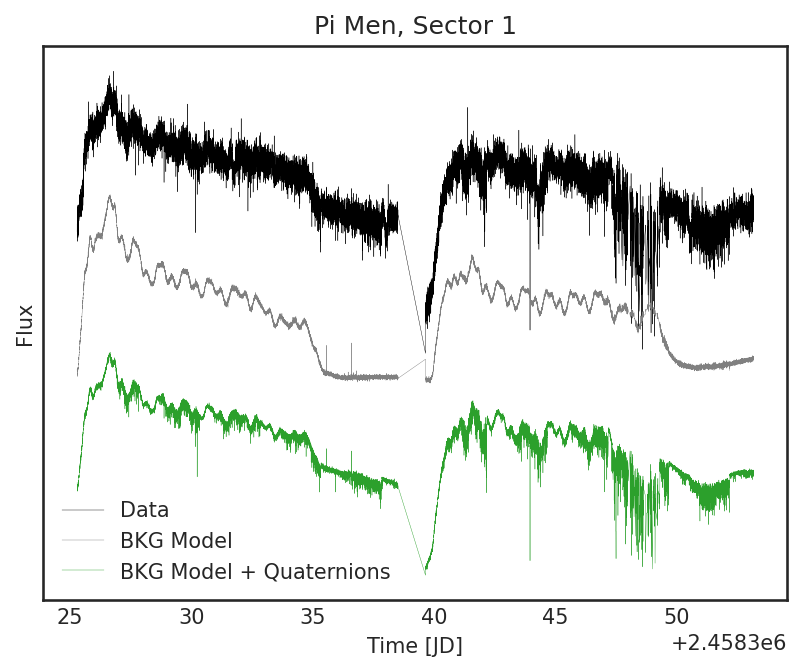

In [19]:
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(dpi=150)
    plt.plot(lc.time.jd, lc.flux, c="k", lw=0.2, label="Data")
    plt.plot(lc.time.jd, bkg * 0.998, c="grey", lw=0.2, label="BKG Model")
    plt.plot(
        lc.time.jd, full_model * 0.996, c="C2", lw=0.2, label="BKG Model + Quaternions"
    )
    ax.set(xlabel="Time [JD]", ylabel="Flux", yticks=[], title="Pi Men, Sector 1")
    plt.legend()

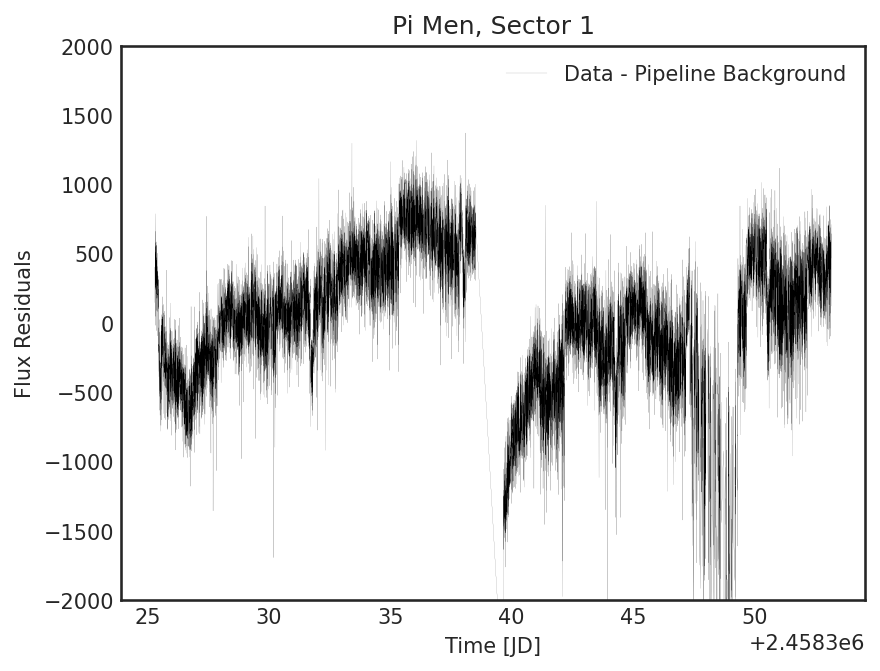

In [20]:
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(dpi=150)
    plt.plot(
        lc.time.jd,
        lc.flux.value - bkg,
        c="k",
        lw=0.05,
        label="Data - Pipeline Background",
    )
    ax.set(
        xlabel="Time [JD]",
        ylabel="Flux Residuals",
        title="Pi Men, Sector 1",
        ylim=(-2000, 2000),
    )
    plt.legend()

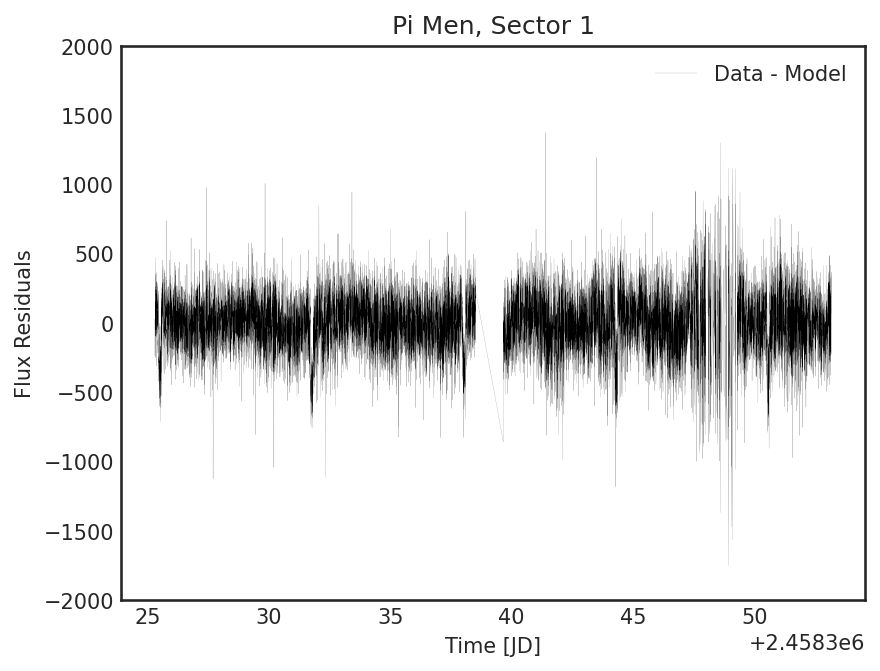

In [21]:
with plt.style.context("seaborn-white"):
    fig, ax = plt.subplots(dpi=150)
    plt.plot(lc.time.jd, lc.flux.value - full_model, c="k", lw=0.05, label="Data - Model")
    ax.set(
        xlabel="Time [JD]",
        ylabel="Flux Residuals",
        title="Pi Men, Sector 1",
        ylim=(-2000, 2000),
    )
    plt.legend()

### Selection of TESS observations with a low scattered-light background 
TESS observes from a unique elliptical high Earth orbit (HEO) that provides an unobstructed view of its field to obtain continuous light curves and a more stable platform for precise photometry than the low Earth orbit. The nominal perigee and apogee of of the elliptical orbit are 17 Earth radii and 59 Earth radii, respectively. The exact orbital period varies between 12-15 days. The orbit places the spacecraft in a 2:1 resonance with the Moon.  

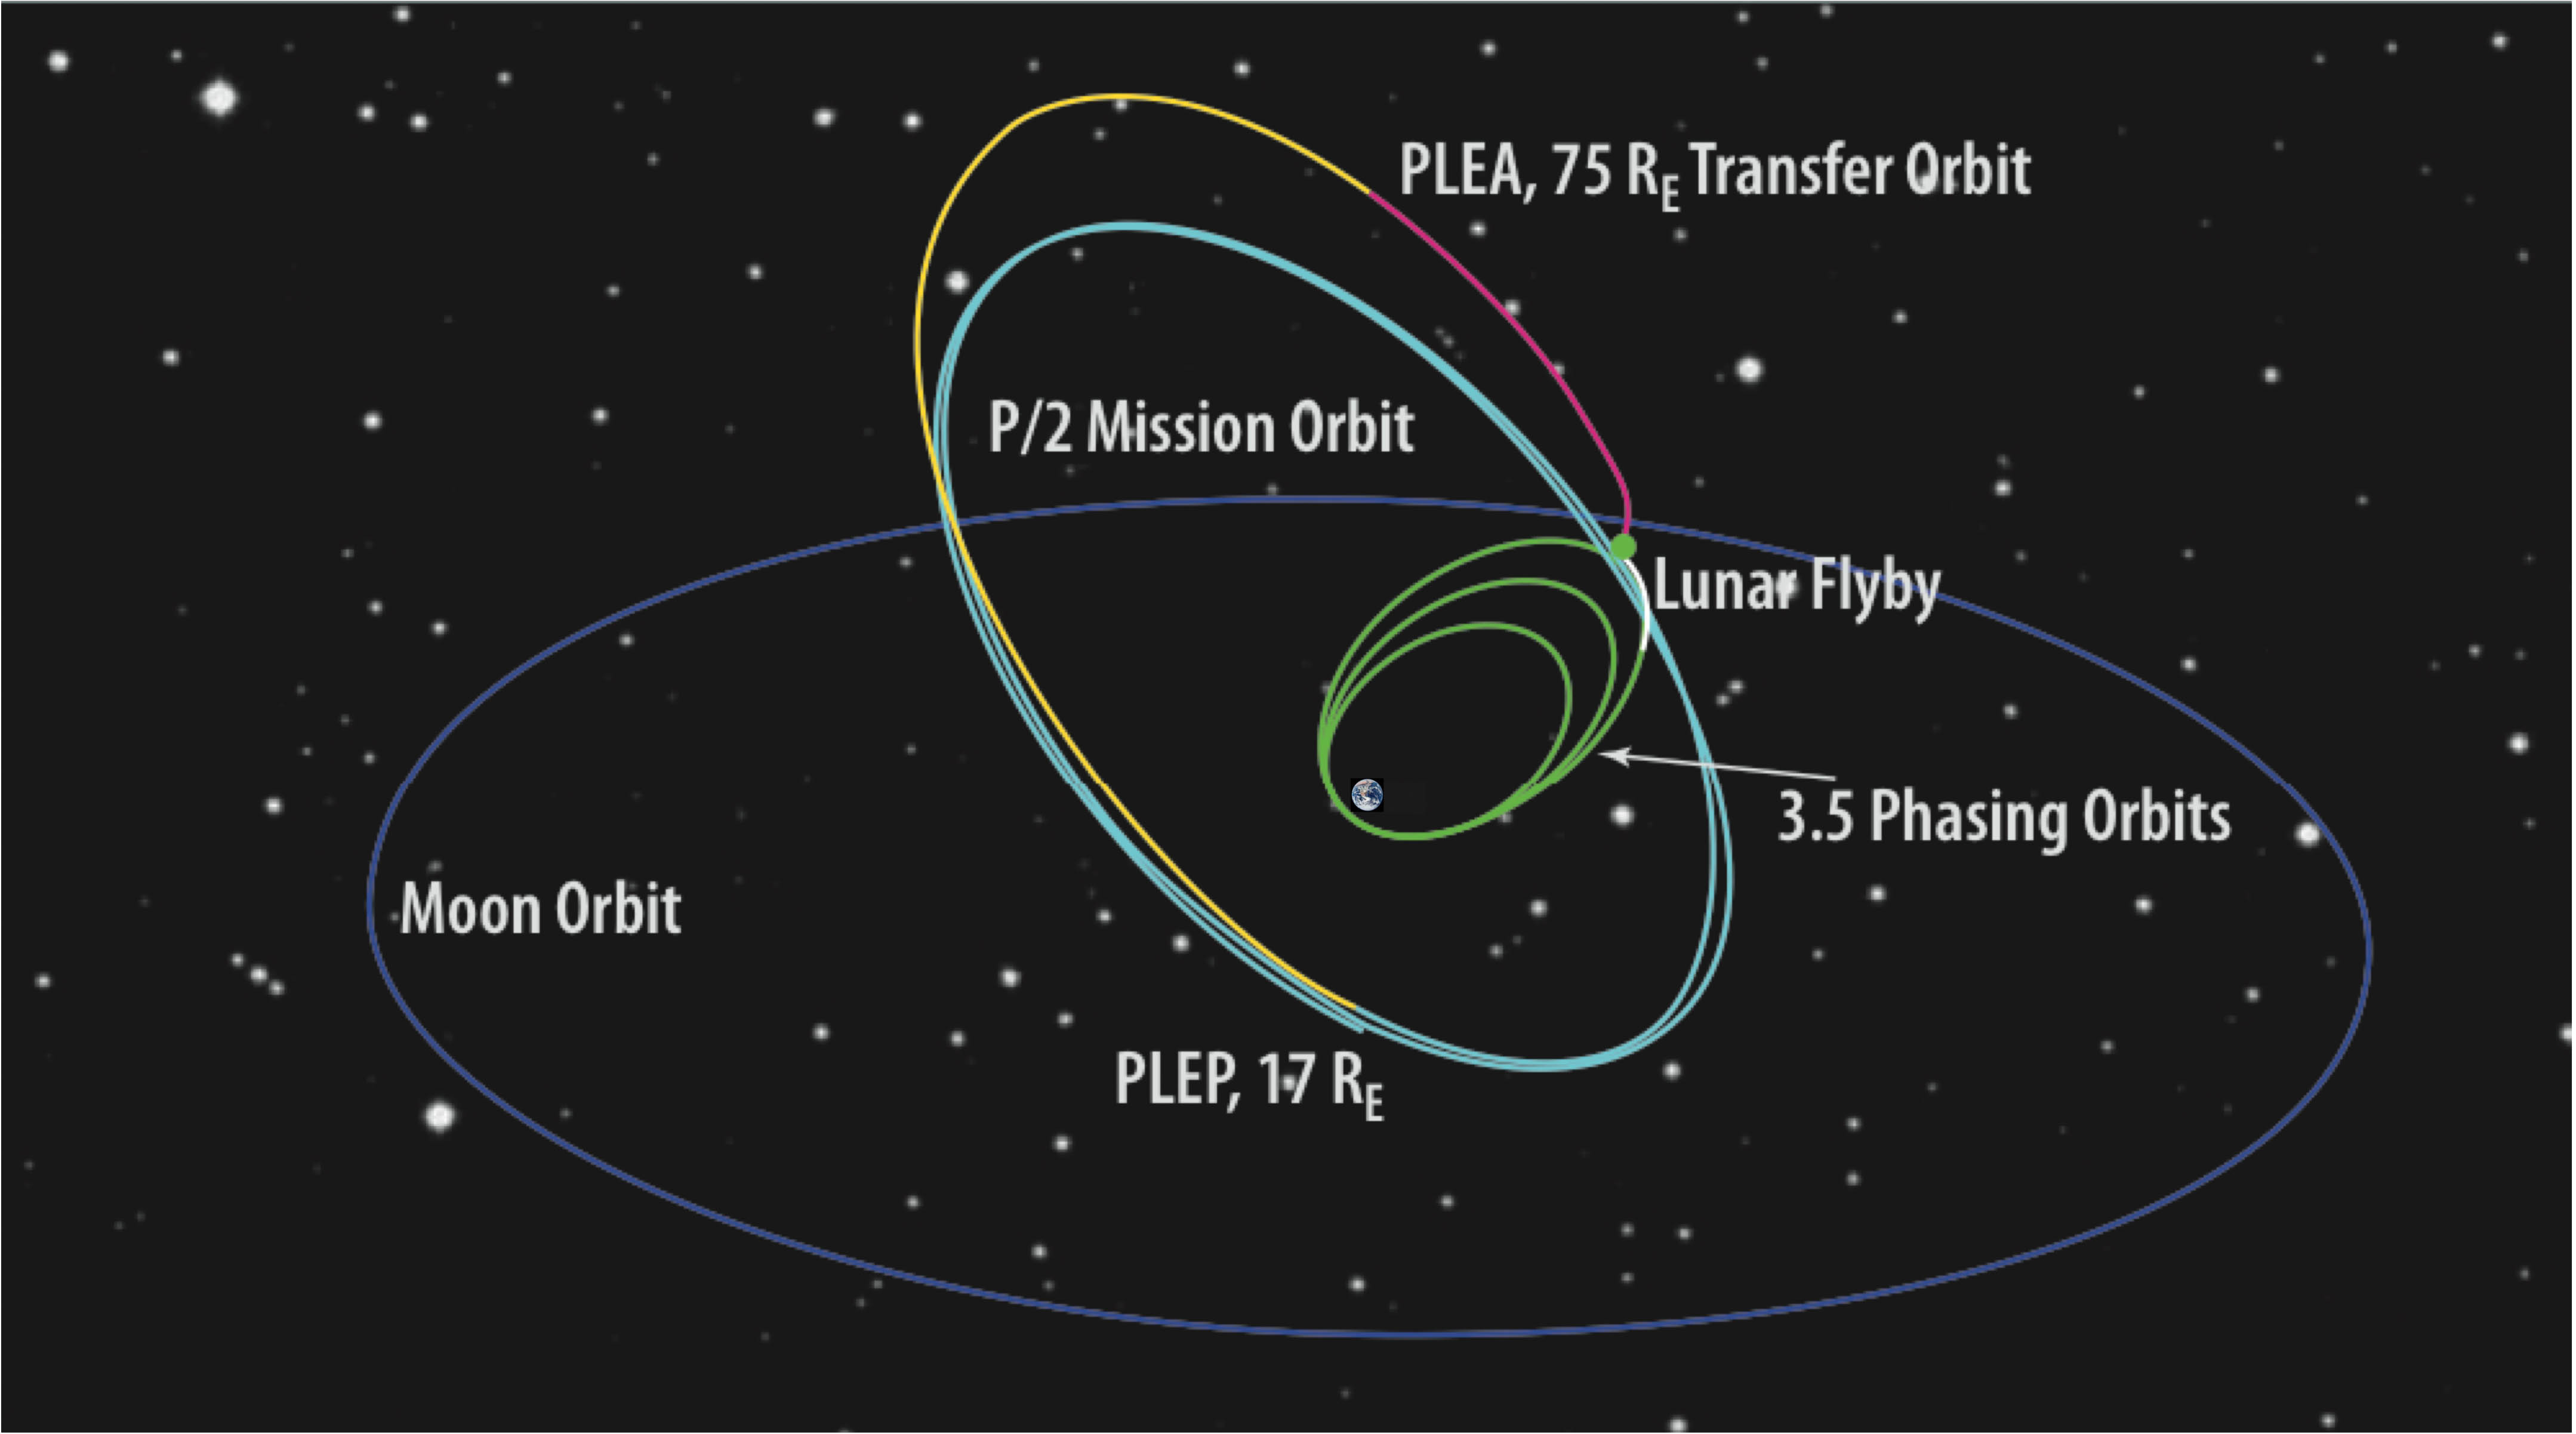
*Image Credit: Ricker et al. (2015)*

This elliptical, high Earth orbit means that the TESS scattered light sky background can vary drammattically based on where TESS is in relation to the Earth, Moon, and Sun.  You can watch a video of this happening [here](https://www.youtube.com/watch?v=SP4QSF9G6FA).  

Here we will demonstrate how to use the earth & moon information to select for low-background frames, and to track the TESS orbit.  


#### Selecting Dark Frames

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

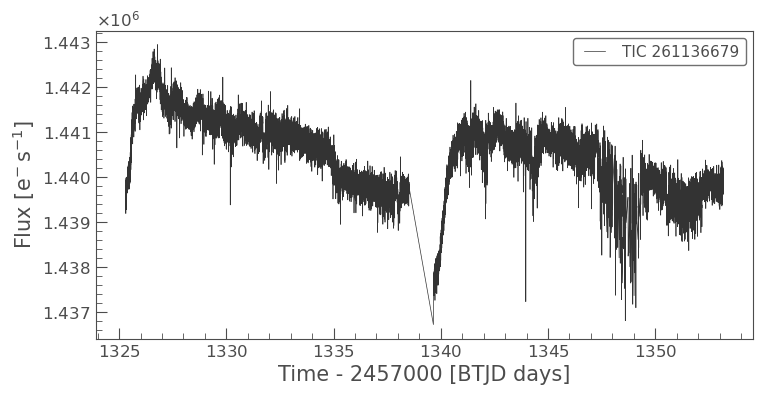

In [38]:
df = pd.read_csv(f"{TESSVectors_Loc}/TessQuats_S001_C4_120.csv", comment="#")
lc = lcs[0]
lc.plot()

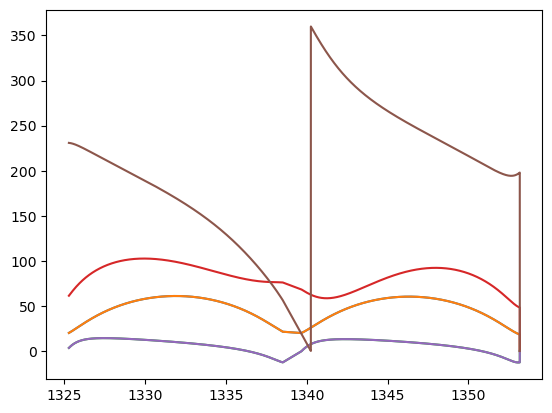

In [37]:
plt.plot(df.MidTime, df.Earth_Distance)
plt.plot(df.MidTime, df.Earth_Camera_Angle)
plt.plot(df.MidTime, df.Earth_Camera_Azimuth)
plt.plot(df.MidTime, df.Moon_Distance)
plt.plot(df.MidTime, df.Moon_Camera_Angle)
plt.plot(df.MidTime, df.Moon_Camera_Azimuth)
        

#### Reconstructing the TESS Orbit

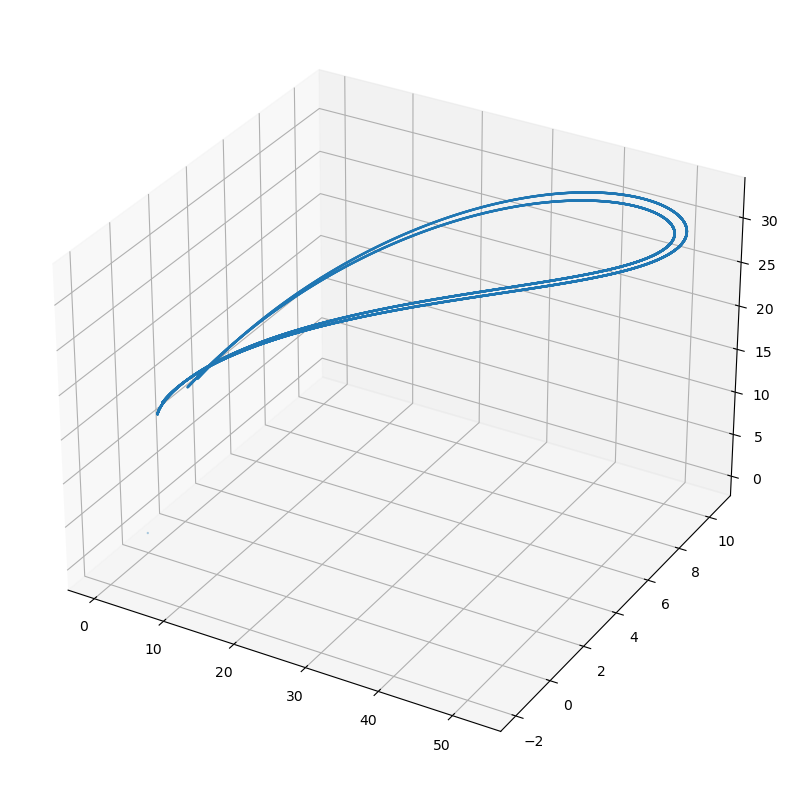

In [31]:
import mpl_toolkits.mplot3d.axes3d as axes3d

THETA, PHI = np.deg2rad(np.asarray(df.Earth_Camera_Azimuth)), np.deg2rad(np.asarray(df.Earth_Camera_Angle))
R = np.asarray(df.Earth_Distance)

X = R * np.sin(PHI) * np.cos(THETA)
Y = R * np.sin(PHI) * np.sin(THETA)
Z = R * np.cos(PHI)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1, projection='3d')
plot = ax.scatter(X, Y, Z, s=0.5)#,c=np.median(f, axis=(1, 2)), rstride=1, cstride=1, cmap=plt.get_cmap('jet'),
#    linewidth=0, antialiased=False, alpha=0.5)

plt.show()

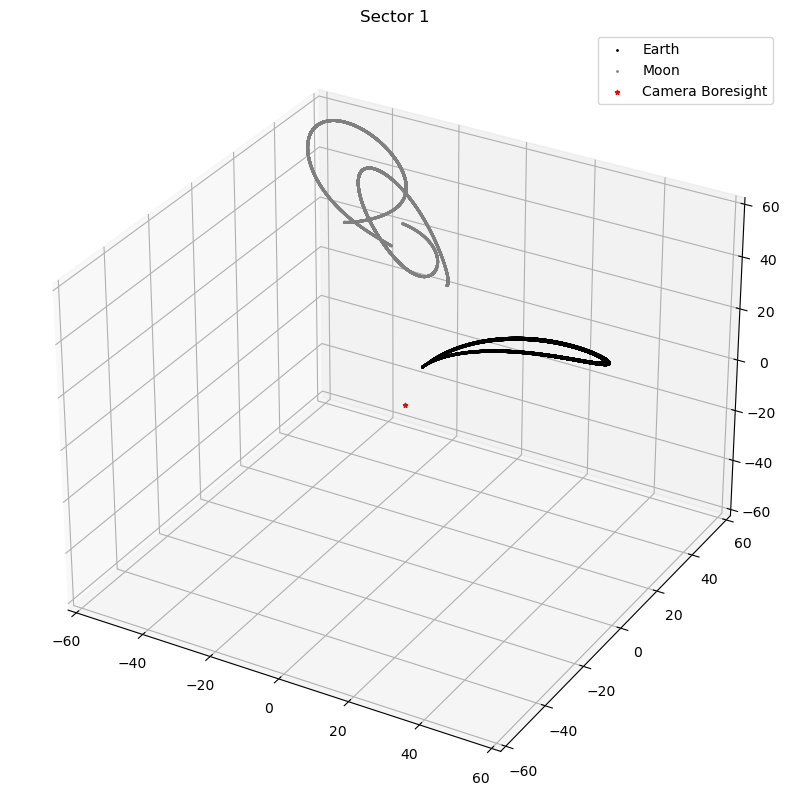

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d


fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1, projection='3d')

for body, color in zip(['Earth', 'Moon'], ['black', 'grey']):
    THETA, PHI = np.deg2rad(np.asarray(df[f"{body}_Camera_Azimuth"])), np.deg2rad(np.asarray(df[f"{body}_Camera_Angle"]))
    R = np.asarray(df[f"{body}_Distance"])

    X = R * np.sin(PHI) * np.cos(THETA)
    Y = R * np.sin(PHI) * np.sin(THETA)
    Z = R * np.cos(PHI)
    ax.scatter(X, Y, Z, c=color, s=1, label=body)
ax.scatter(0, 0, 0, c='red', s=10, marker='*', label='Camera Boresight')
ax.legend()
ax.set(xlim=(-60, 60), ylim=(-60, 60), zlim=(-60, 60), title='Sector 1')
plt.show()